#Librerias

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocesamiento y transformación de datos
from sklearn.preprocessing import StandardScaler

# División de datos
from sklearn.model_selection import train_test_split, GridSearchCV

# Modelos de Machine Learning
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    BaggingClassifier,
    AdaBoostClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

# Análisis de componentes y reducción de dimensionalidad
from sklearn import decomposition

# Evaluación de modelos
from sklearn.metrics import classification_report
from yellowbrick.model_selection import FeatureImportances
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Estadística y análisis de datos
from scipy.stats import mode
from scipy.stats.mstats import winsorize

# Clustering jerárquico
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist, squareform


#Procesamiennto data base

In [2]:
df = pd.read_csv('/content/diabetes.csv')

In [3]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [4]:
print(df.shape)
print(df.info())
print(df['Outcome'].value_counts())

(768, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None
Outcome
0    500
1    268
Name: count, dtype: int64


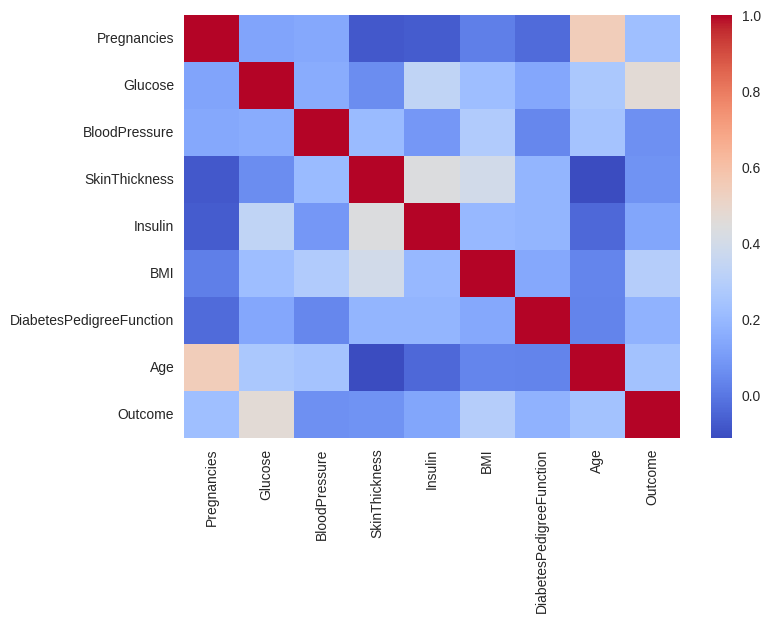

In [5]:
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.savefig('heatmap.pdf')
plt.show()

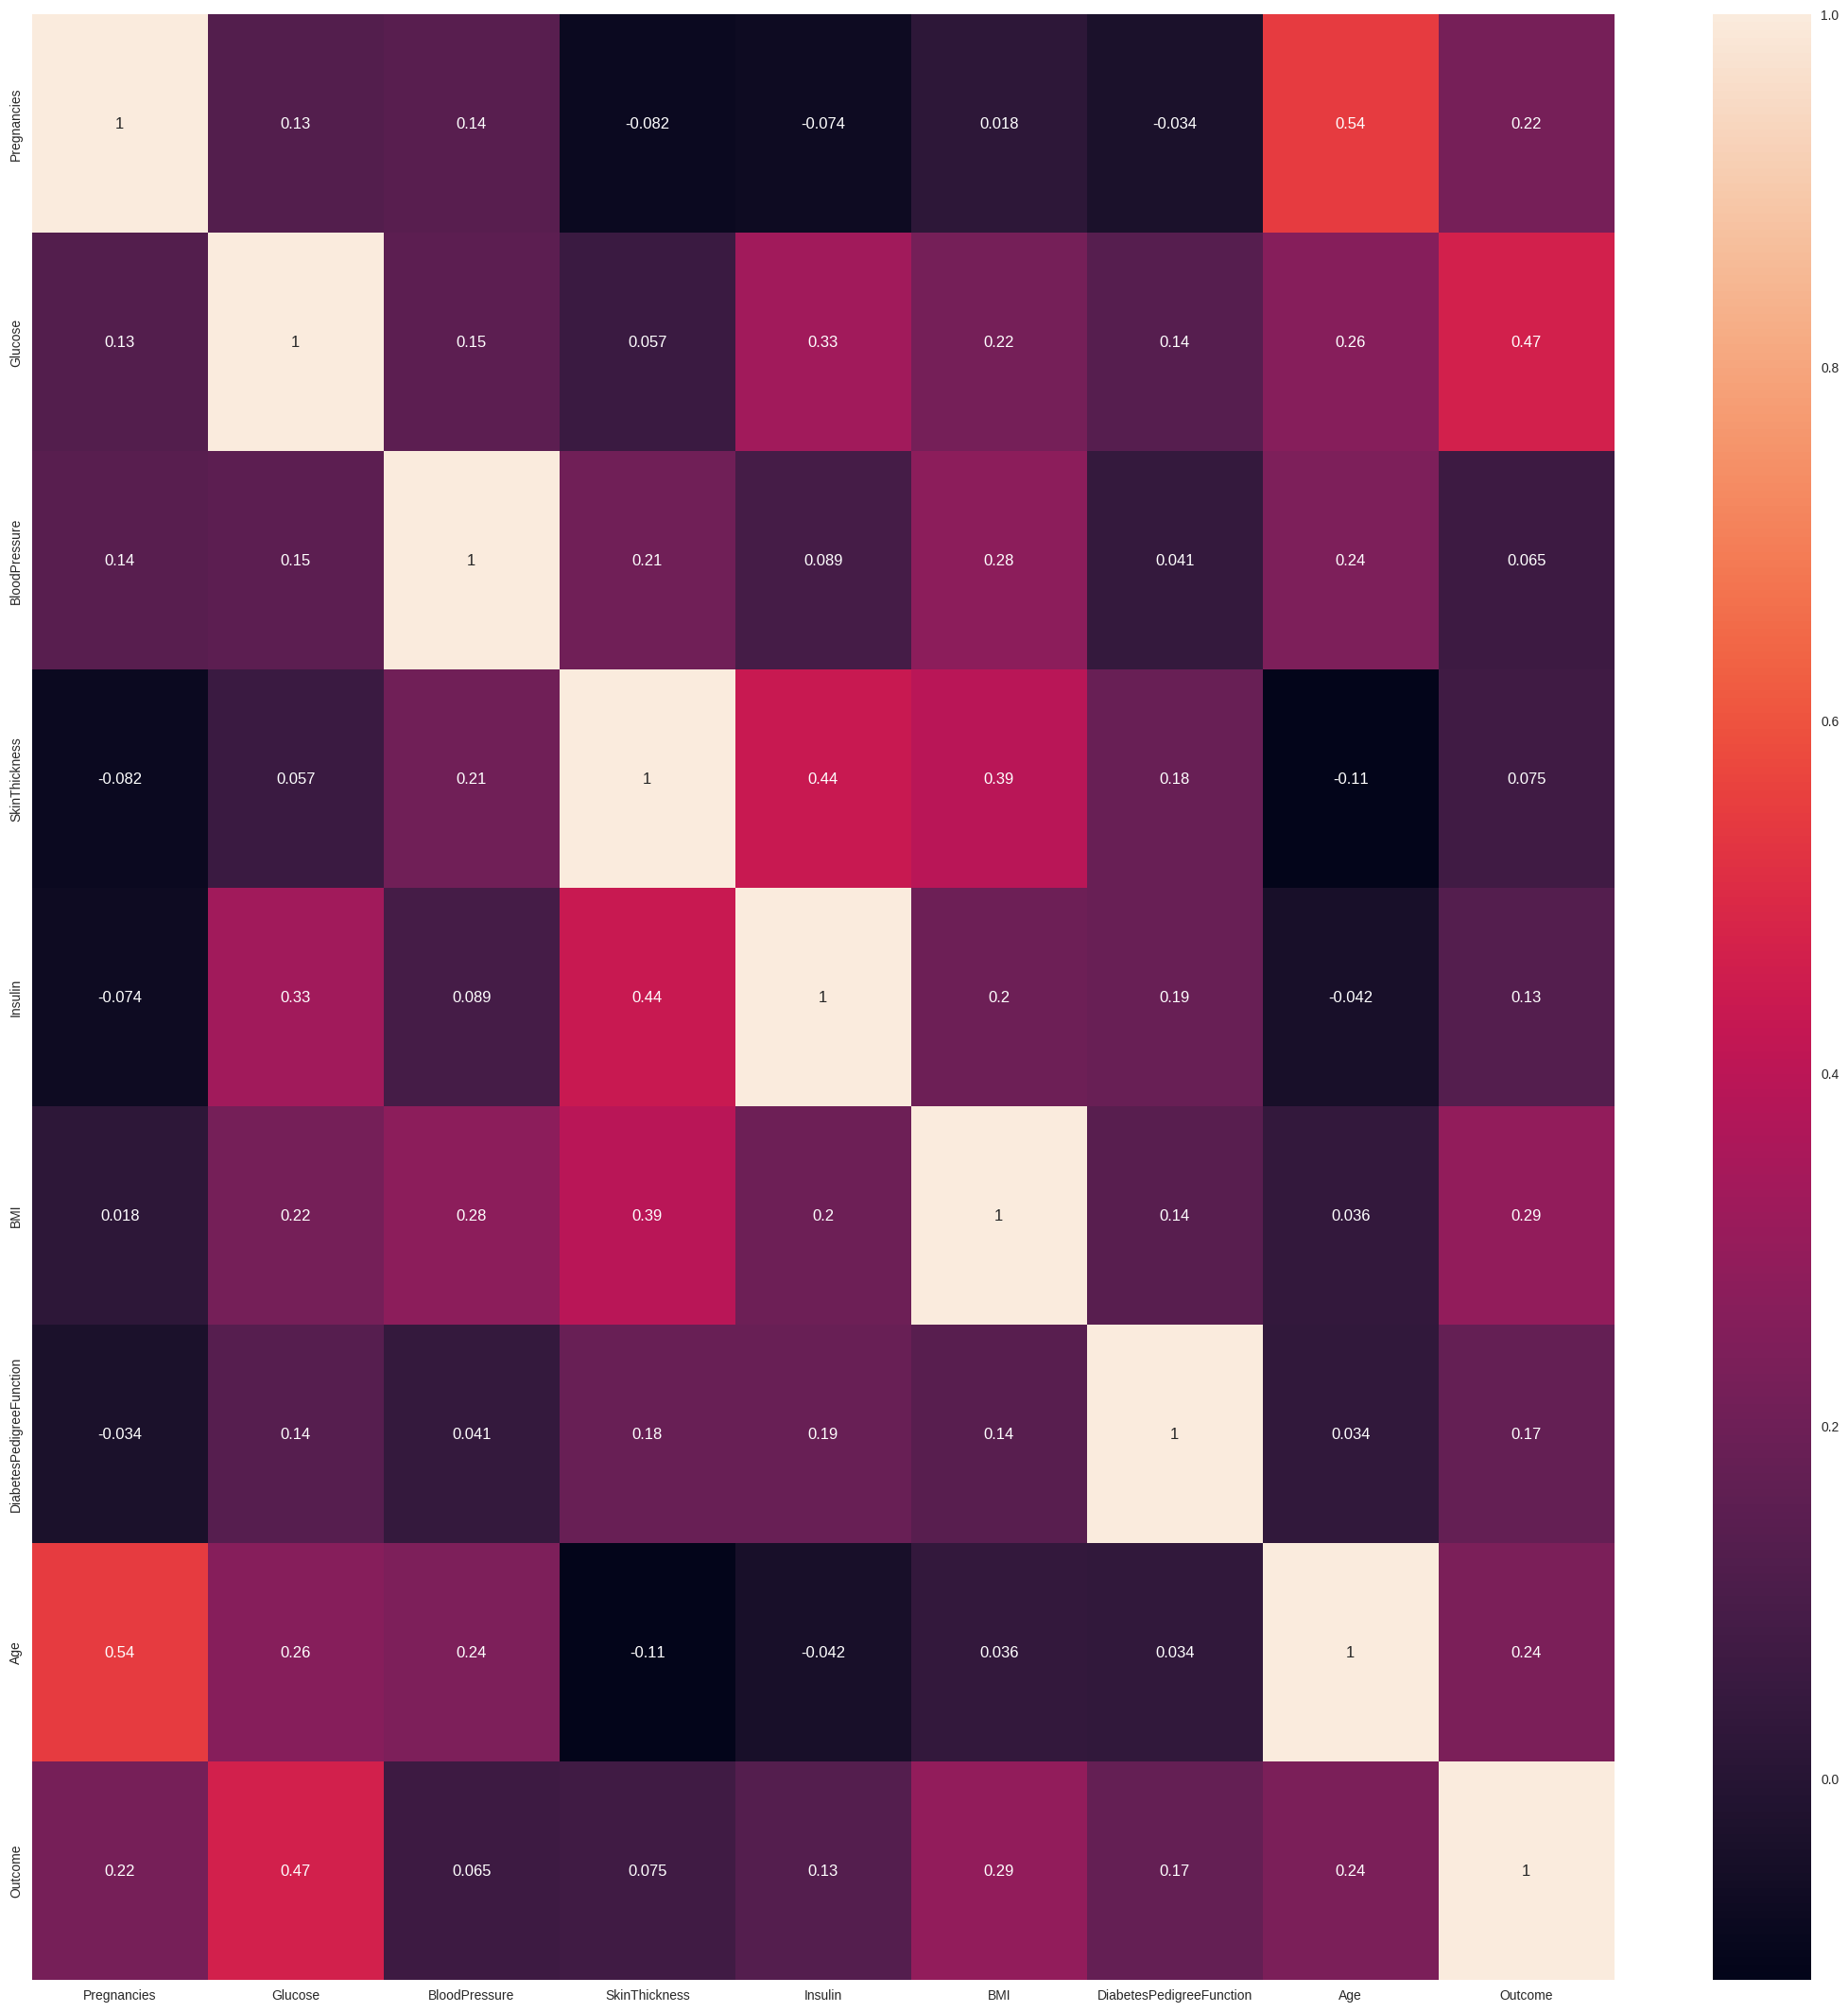

In [6]:
corr_df = df.corr(method='pearson')
plt.figure(figsize=(27, 27))
sns.heatmap(corr_df, annot=True)
plt.savefig('pearson.pdf')
plt.show()

In [7]:
registros_duplicados = df.duplicated().sum()
print("Registros duplicados:", registros_duplicados)

Registros duplicados: 0


In [8]:
df=df.drop_duplicates()

In [9]:
len(df.columns)

9

In [10]:
#df.describe()

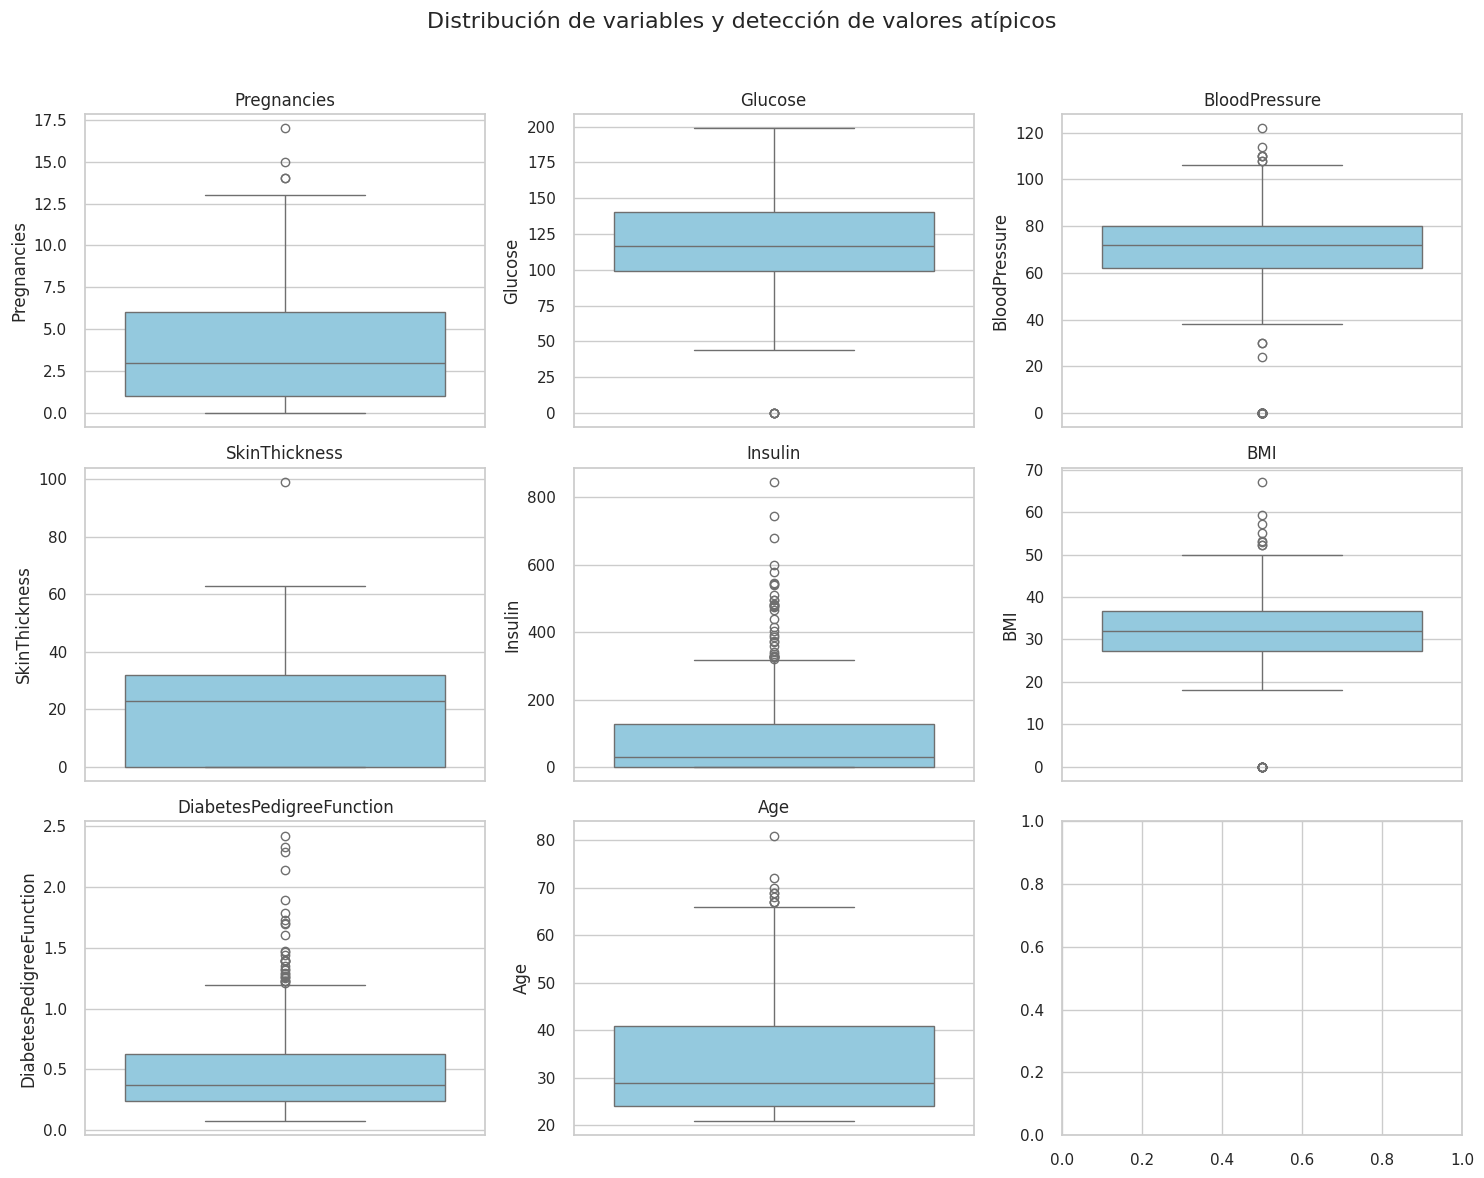

In [11]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle("Distribución de variables y detección de valores atípicos", fontsize=16)

columns = df.columns[:-1]  # Excluir la variable Outcome
for i, col in enumerate(columns):
    row, col_idx = divmod(i, 3)
    sns.boxplot(y=df[col], ax=axes[row, col_idx], color="skyblue")
    axes[row, col_idx].set_title(col)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [12]:
for col in df.columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    umbral_superior = Q3 + 1.5 * IQR
    umbral_inferior = Q1 - 1.5 * IQR
    valores_atipicos = df[(df[col] > umbral_superior) | (df[col] < umbral_inferior)]
    print(f"La variable '{col}' tiene {len(valores_atipicos)} valores atípicos.")

La variable 'Pregnancies' tiene 4 valores atípicos.
La variable 'Glucose' tiene 5 valores atípicos.
La variable 'BloodPressure' tiene 45 valores atípicos.
La variable 'SkinThickness' tiene 1 valores atípicos.
La variable 'Insulin' tiene 34 valores atípicos.
La variable 'BMI' tiene 19 valores atípicos.
La variable 'DiabetesPedigreeFunction' tiene 29 valores atípicos.
La variable 'Age' tiene 9 valores atípicos.
La variable 'Outcome' tiene 0 valores atípicos.


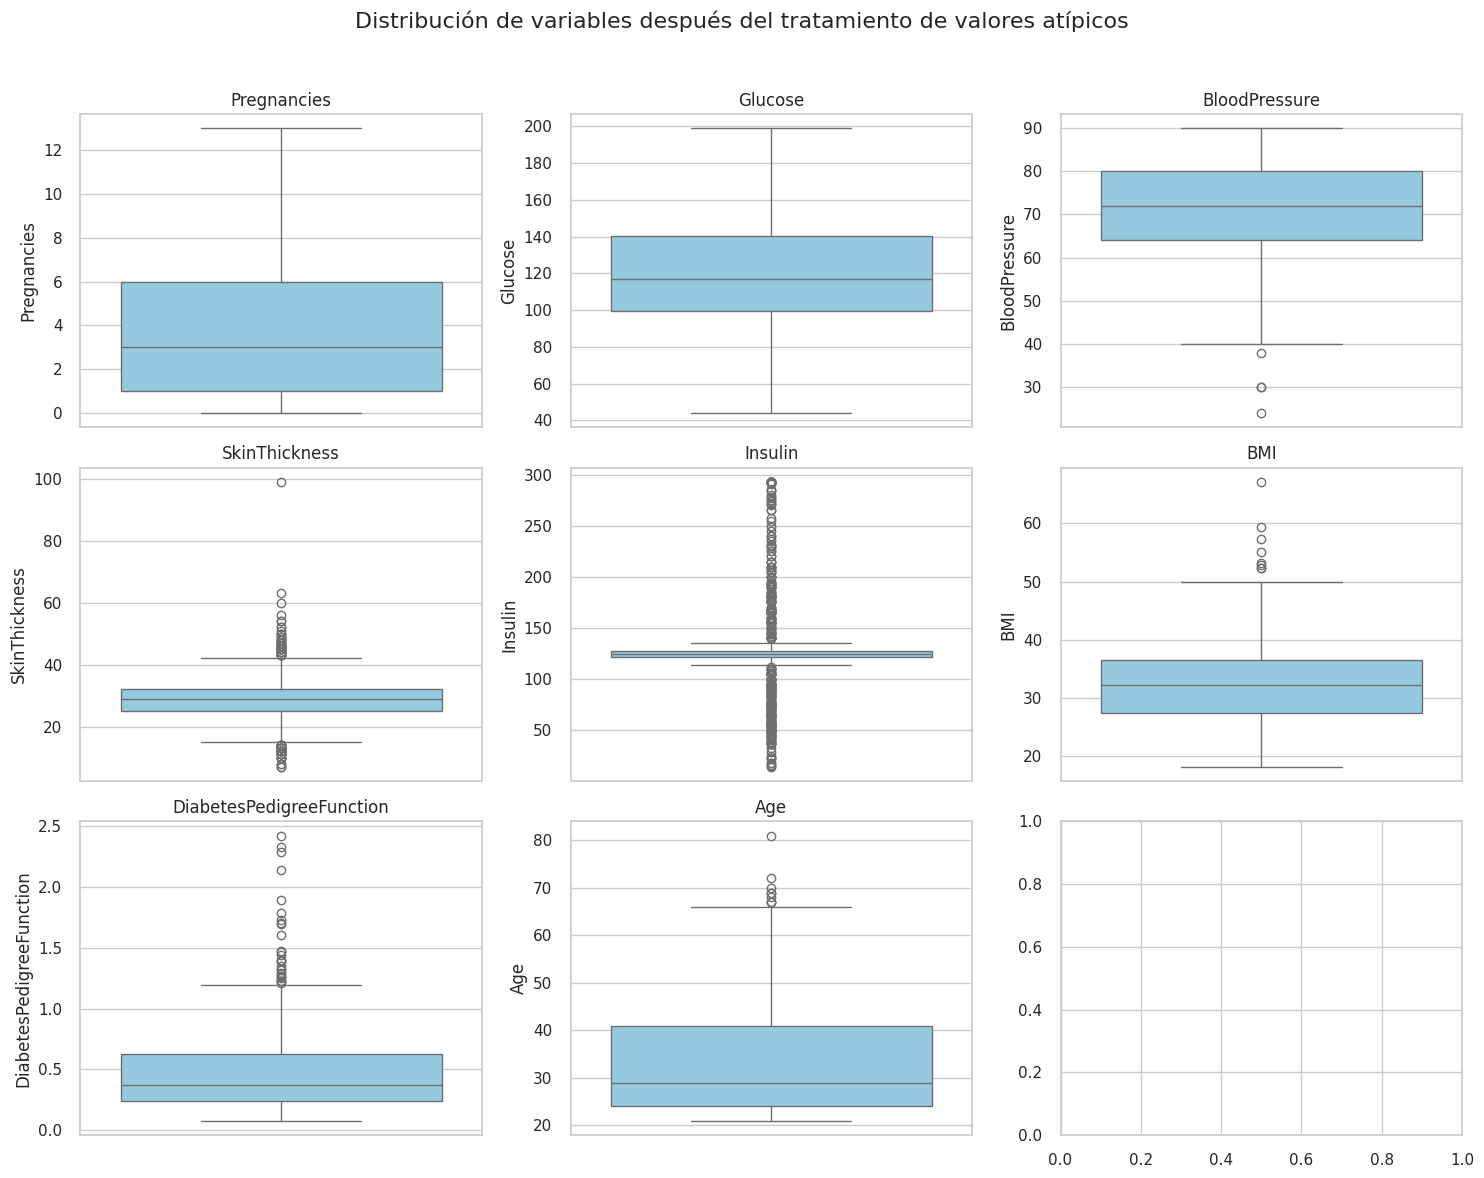

In [13]:
columns_to_fix = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
for col in columns_to_fix:
    median_value = df[col].replace(0, pd.NA).median()  # Evita que los ceros afecten el cálculo
    df[col] = df[col].replace(0, median_value)


# Winsorization para limitar valores extremos
winsor_limits = {
    "Pregnancies": [0, 0.01],  # Eliminar solo el 1% superior
    "Insulin": [0, 0.05],  # Eliminar el 5% superior
    "BloodPressure": [0, 0.05]  # Eliminar el 5% superior
}

for col, limits in winsor_limits.items():
    df[col] = winsorize(df[col], limits=limits)

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle("Distribución de variables después del tratamiento de valores atípicos", fontsize=16)

columns = df.drop(columns=["Outcome"]).columns  # Excluir la variable objetivo
for i, col in enumerate(columns):
    row, col_idx = divmod(i, 3)
    sns.boxplot(y=df[col], ax=axes[row, col_idx], color="skyblue")
    axes[row, col_idx].set_title(col)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Aplicamos este tratamiento para mejorar la calidad de los datos y optimizar la predicción de diabetes. Eliminamos valores atípicos usando IQR para reducir sesgos, reemplazamos ceros en variables fisiológicas (Glucose, BloodPressure, SkinThickness, Insulin, BMI) con la mediana porque no tienen sentido fisiológico, y aplicamos Winsorization en Pregnancies, Insulin y BloodPressure para limitar valores extremos sin eliminarlos. Finalmente, visualizamos los cambios con boxplots para asegurar una distribución más controlada y representativa.

In [14]:
labels = df['Outcome'].values
features = df.drop(['Outcome'],axis=1).values


print('Features shape:', features.shape)
print('Labels shape:', labels.shape)

Features shape: (768, 8)
Labels shape: (768,)


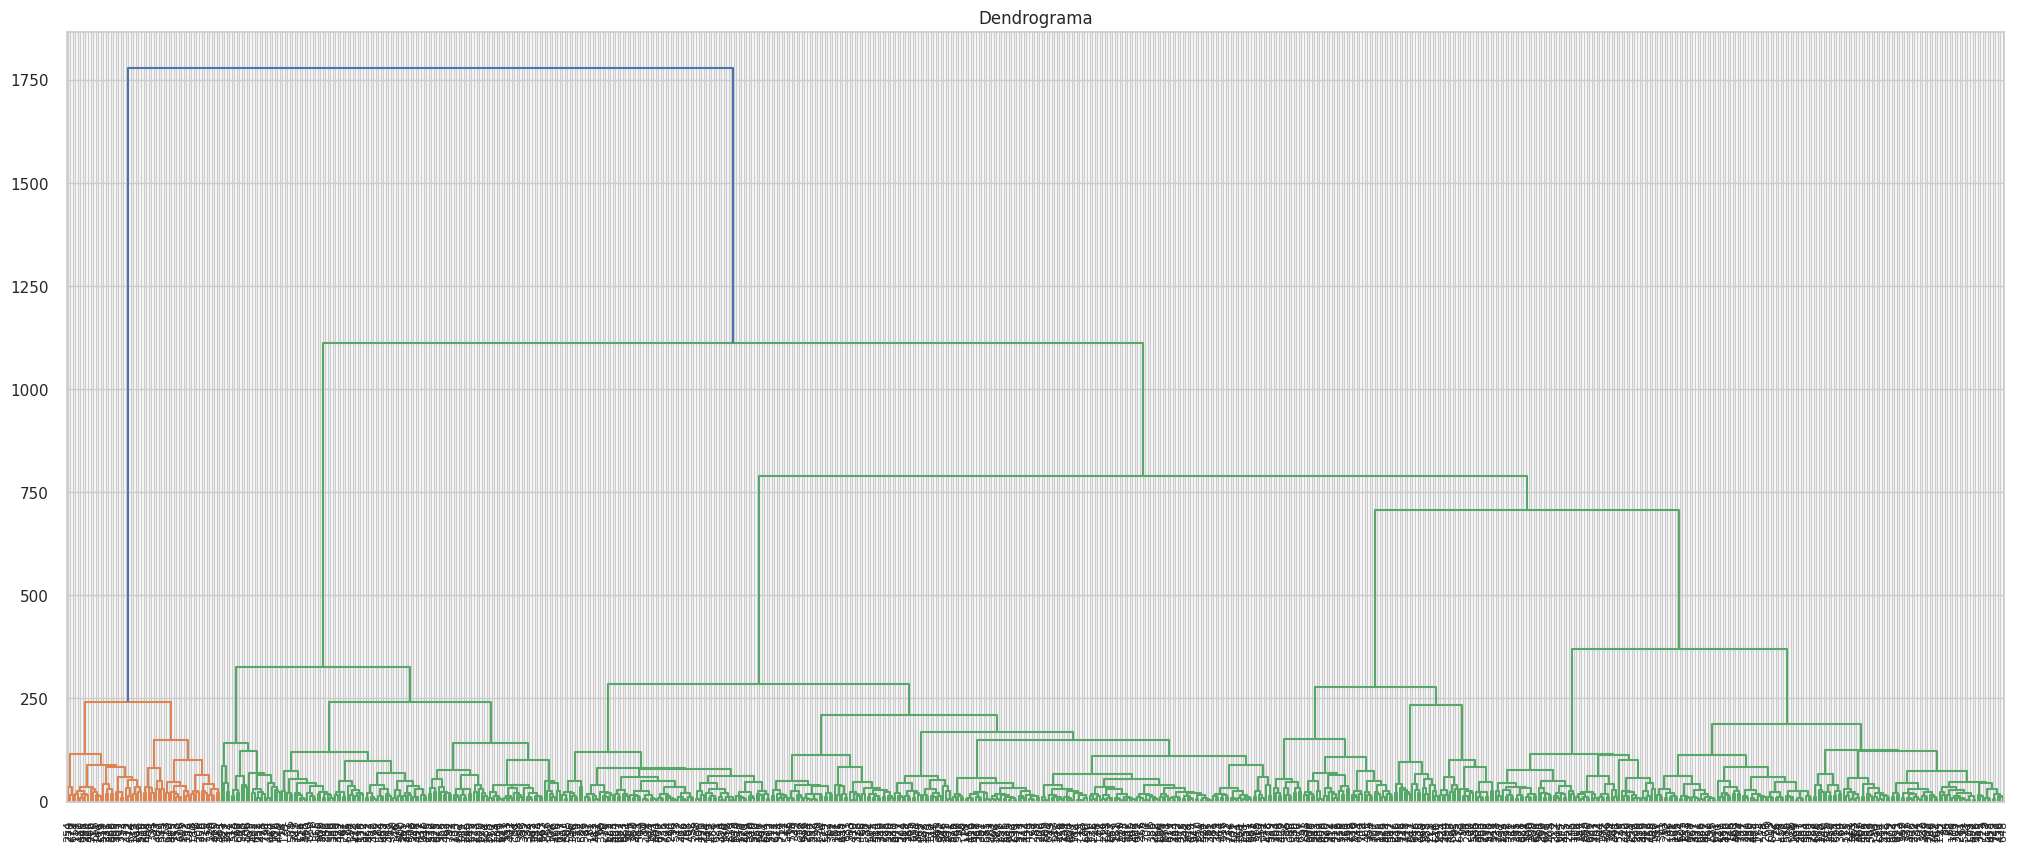

In [15]:
x=df.drop(['Outcome'],axis=1).values
# generate the linkage matrix
# Performs hierarchical/agglomerative clustering.
Z = linkage(x,method='ward',metric='euclidean')

# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Dendrograma')

dendrogram(
           Z,
           leaf_rotation=90.,  # rotates the x axis labels
           leaf_font_size=8.,  # font size for the x axis labels
           )
plt.savefig('dendograma.pdf')
plt.show()

In [16]:
# Copiamos el dataframe preprocesado para utilizarlo más adelante
df_copy1 = df.copy()
df_copy2 = df.copy()
df_copy3 = df.copy()
df_copy4 = df.copy()
df_copy5 = df.copy()
df_copy6 = df.copy()

#Any o SinPCA Sin Normalizar


In [17]:
df1 = pd.read_csv('/content/diabetes.csv')
X_train, X_test, y_train, y_test = train_test_split(features, labels,test_size=0.20, random_state=1, stratify=labels)
y_train= y_train[:].astype(int)
y_test=y_test[:].astype(int)

In [18]:
model_DTC = DecisionTreeClassifier(random_state=0)
model_MLP = MLPClassifier(random_state=0, max_iter=500)  # Increased max_iter for MLP
model_KNN = KNeighborsClassifier()
model_SGDC = SGDClassifier(random_state=0)
model_ETC = ExtraTreesClassifier(random_state=0)
model_RF = RandomForestClassifier(random_state=0)
model_GB = GradientBoostingClassifier(random_state=0)

In [19]:
model_DTC.fit(X_train, y_train)
model_MLP.fit(X_train, y_train)
model_KNN.fit(X_train, y_train)
model_SGDC.fit(X_train, y_train)
model_ETC.fit(X_train, y_train)
model_RF.fit(X_train, y_train)
model_GB.fit(X_train, y_train)

GradientBoostingClassifier(random_state=0)

In [20]:
print("DTC, Accuracy: ", model_DTC.score(X_test, y_test))
print("MLP, Accuracy: ", model_MLP.score(X_test, y_test))
print("KNN, Accuracy: ", model_KNN.score(X_test, y_test))
print("SGDC, Accuracy: ", model_SGDC.score(X_test, y_test))
print("ETC, Accuracy: ", model_ETC.score(X_test, y_test))
print("RF, Accuracy: ", model_RF.score(X_test, y_test))
print("GB, Accuracy: ", model_GB.score(X_test, y_test))

DTC, Accuracy:  0.7207792207792207
MLP, Accuracy:  0.7142857142857143
KNN, Accuracy:  0.7272727272727273
SGDC, Accuracy:  0.6883116883116883
ETC, Accuracy:  0.7597402597402597
RF, Accuracy:  0.7467532467532467
GB, Accuracy:  0.7597402597402597


In [21]:
models = {
    "DTC": model_DTC,
    "MLP": model_MLP,
    "KNN": model_KNN,
    "SGDC": model_SGDC,
    "ETC": model_ETC,
    "RF": model_RF,
    "GB": model_GB
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred) * 100
    precision = precision_score(y_test, y_pred, average='weighted') * 100
    recall = recall_score(y_test, y_pred, average='weighted') * 100
    f1 = f1_score(y_test, y_pred, average='weighted') * 100

    print(f"{name}, Accuracy: {accuracy:.2f}%, Precision: {precision:.2f}%, Recall: {recall:.2f}%, F1: {f1:.2f}%")


DTC, Accuracy: 72.08%, Precision: 71.26%, Recall: 72.08%, F1: 71.41%
MLP, Accuracy: 71.43%, Precision: 71.29%, Recall: 71.43%, F1: 67.80%
KNN, Accuracy: 72.73%, Precision: 72.01%, Recall: 72.73%, F1: 72.16%
SGDC, Accuracy: 68.83%, Precision: 69.71%, Recall: 68.83%, F1: 69.17%
ETC, Accuracy: 75.97%, Precision: 75.43%, Recall: 75.97%, F1: 74.87%
RF, Accuracy: 74.68%, Precision: 74.01%, Recall: 74.68%, F1: 74.07%
GB, Accuracy: 75.97%, Precision: 75.46%, Recall: 75.97%, F1: 75.55%


In [22]:
# Definimos el modelo que se desea tunear
model_GB  = GradientBoostingClassifier()

# Se definen los hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Se crea la grilla con los hiperparámetros
grid_search  = GridSearchCV(model_GB,param_grid,cv=5,verbose=0)

# Se ejecuta la grilla con el modelo
grid_search.fit(X_train,y_train)
best_params = grid_search.best_params_

print("Mejores hiperparámetros:", best_params)

Mejores hiperparámetros: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 200}


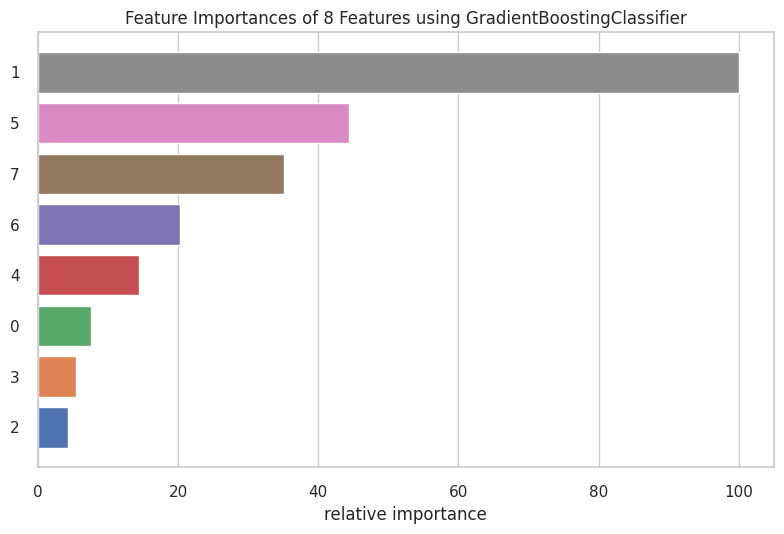

<Figure size 800x550 with 0 Axes>

In [23]:
model = GradientBoostingClassifier(learning_rate=0.01, max_depth=4, n_estimators=200)
model.fit(X_train, y_train)

# Mostrar la importancia de características
viz = FeatureImportances(model)
viz.fit(X_train, y_train)
viz.show()
plt.savefig('NoPCANoNOrm.pdf')

#PCA Sin Normalizar - Análisis de Componentes Principales


In [24]:
dfc1 = df_copy1
X_train, X_test, y_train, y_test = train_test_split(features, labels,test_size=0.20, random_state=1, stratify=labels)
y_train= y_train[:].astype(int)
y_test=y_test[:].astype(int)

In [25]:
pca = decomposition.PCA(n_components=0.96,svd_solver='full',tol=1e-4)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test=pca.transform(X_test)

In [26]:
model_DTC = DecisionTreeClassifier(random_state=0)
model_MLP = MLPClassifier(random_state=0, max_iter=500)  # Increased max_iter for MLP
model_KNN = KNeighborsClassifier()
model_SGDC = SGDClassifier(random_state=0)
model_ETC = ExtraTreesClassifier(random_state=0)
model_RF = RandomForestClassifier(random_state=0)
model_GB = GradientBoostingClassifier(random_state=0)

In [27]:
model_DTC.fit(X_train, y_train)
model_MLP.fit(X_train, y_train)
model_KNN.fit(X_train, y_train)
model_SGDC.fit(X_train, y_train)
model_ETC.fit(X_train, y_train)
model_RF.fit(X_train, y_train)
model_GB.fit(X_train, y_train)

GradientBoostingClassifier(random_state=0)

In [28]:
print("DTC, Accuracy: ", model_DTC.score(X_test, y_test))
print("MLP, Accuracy: ", model_MLP.score(X_test, y_test))
print("KNN, Accuracy: ", model_KNN.score(X_test, y_test))
print("SGDC, Accuracy: ", model_SGDC.score(X_test, y_test))
print("ETC, Accuracy: ", model_ETC.score(X_test, y_test))
print("RF, Accuracy: ", model_RF.score(X_test, y_test))
print("GB, Accuracy: ", model_GB.score(X_test, y_test))

DTC, Accuracy:  0.6818181818181818
MLP, Accuracy:  0.7532467532467533
KNN, Accuracy:  0.7077922077922078
SGDC, Accuracy:  0.7142857142857143
ETC, Accuracy:  0.7532467532467533
RF, Accuracy:  0.7727272727272727
GB, Accuracy:  0.7467532467532467


In [29]:
models = {
    "DTC": model_DTC,
    "MLP": model_MLP,
    "KNN": model_KNN,
    "SGDC": model_SGDC,
    "ETC": model_ETC,
    "RF": model_RF,
    "GB": model_GB
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred) * 100
    precision = precision_score(y_test, y_pred, average='weighted') * 100
    recall = recall_score(y_test, y_pred, average='weighted') * 100
    f1 = f1_score(y_test, y_pred, average='weighted') * 100

    print(f"{name}, Accuracy: {accuracy:.2f}%, Precision: {precision:.2f}%, Recall: {recall:.2f}%, F1: {f1:.2f}%")

DTC, Accuracy: 68.18%, Precision: 67.56%, Recall: 68.18%, F1: 67.80%
MLP, Accuracy: 75.32%, Precision: 75.03%, Recall: 75.32%, F1: 73.64%
KNN, Accuracy: 70.78%, Precision: 69.76%, Recall: 70.78%, F1: 69.88%
SGDC, Accuracy: 71.43%, Precision: 70.33%, Recall: 71.43%, F1: 70.24%
ETC, Accuracy: 75.32%, Precision: 74.65%, Recall: 75.32%, F1: 74.48%
RF, Accuracy: 77.27%, Precision: 76.76%, Recall: 77.27%, F1: 76.58%
GB, Accuracy: 74.68%, Precision: 74.10%, Recall: 74.68%, F1: 74.23%


In [30]:
model_RF = RandomForestClassifier()

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(model_RF, param_grid, cv=5, verbose=0)

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

print("Mejores hiperparámetros:", best_params)

Mejores hiperparámetros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


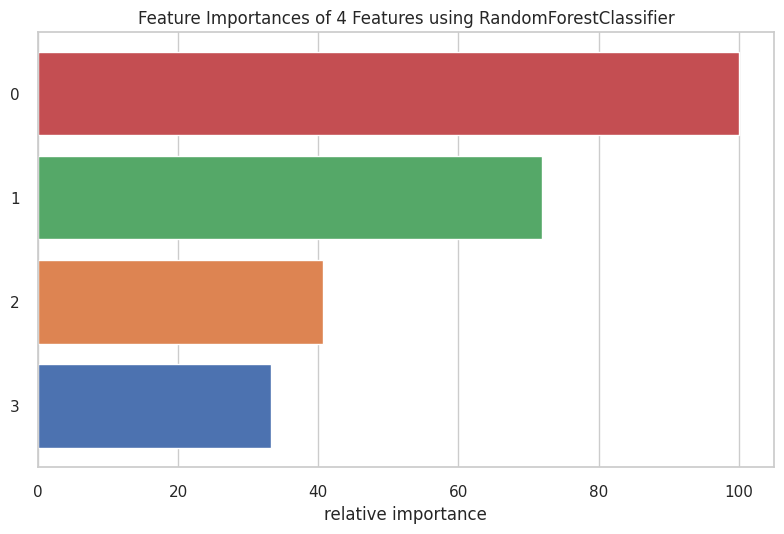

<Axes: title={'center': 'Feature Importances of 4 Features using RandomForestClassifier'}, xlabel='relative importance'>

In [31]:
model = RandomForestClassifier(max_depth= 20, min_samples_leaf= 4, min_samples_split= 10, n_estimators= 50)
model.fit(X_train, y_train)

viz = FeatureImportances(model)
viz.fit(X_train, y_train)
plt.savefig('PCANoNOrm.pdf')
viz.show()


#SinPCA Normalizado - Standard Scaler



In [32]:
dfc2 = df_copy2
X_train, X_test, y_train, y_test = train_test_split(features, labels,test_size=0.20, random_state=1, stratify=labels)
y_train= y_train[:].astype(int)
y_test=y_test[:].astype(int)

In [33]:
#Normalizado
scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [34]:
model_DTC = DecisionTreeClassifier(random_state=0)
model_MLP = MLPClassifier(random_state=0, max_iter=500)  # Increased max_iter for MLP
model_KNN = KNeighborsClassifier()
model_SGDC = SGDClassifier(random_state=0)
model_ETC = ExtraTreesClassifier(random_state=0)
model_RF = RandomForestClassifier(random_state=0)
model_GB = GradientBoostingClassifier(random_state=0)

In [35]:
model_DTC.fit(X_train, y_train)
model_MLP.fit(X_train, y_train)
model_KNN.fit(X_train, y_train)
model_SGDC.fit(X_train, y_train)
model_ETC.fit(X_train, y_train)
model_RF.fit(X_train, y_train)
model_GB.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


GradientBoostingClassifier(random_state=0)

In [36]:
print("DTC, Accuracy: ", model_DTC.score(X_test, y_test))
print("MLP, Accuracy: ", model_MLP.score(X_test, y_test))
print("KNN, Accuracy: ", model_KNN.score(X_test, y_test))
print("SGDC, Accuracy: ", model_SGDC.score(X_test, y_test))
print("ETC, Accuracy: ", model_ETC.score(X_test, y_test))
print("RF, Accuracy: ", model_RF.score(X_test, y_test))
print("GB, Accuracy: ", model_GB.score(X_test, y_test))


DTC, Accuracy:  0.7272727272727273
MLP, Accuracy:  0.7272727272727273
KNN, Accuracy:  0.7207792207792207
SGDC, Accuracy:  0.7077922077922078
ETC, Accuracy:  0.7597402597402597
RF, Accuracy:  0.7532467532467533
GB, Accuracy:  0.7597402597402597


In [37]:
models = {
    "DTC": model_DTC,
    "MLP": model_MLP,
    "KNN": model_KNN,
    "SGDC": model_SGDC,
    "ETC": model_ETC,
    "RF": model_RF,
    "GB": model_GB
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred) * 100
    precision = precision_score(y_test, y_pred, average='weighted') * 100
    recall = recall_score(y_test, y_pred, average='weighted') * 100
    f1 = f1_score(y_test, y_pred, average='weighted') * 100

    print(f"{name}, Accuracy: {accuracy:.2f}%, Precision: {precision:.2f}%, Recall: {recall:.2f}%, F1: {f1:.2f}%")

DTC, Accuracy: 72.73%, Precision: 72.01%, Recall: 72.73%, F1: 72.16%
MLP, Accuracy: 72.73%, Precision: 72.15%, Recall: 72.73%, F1: 72.32%
KNN, Accuracy: 72.08%, Precision: 71.56%, Recall: 72.08%, F1: 71.74%
SGDC, Accuracy: 70.78%, Precision: 70.66%, Recall: 70.78%, F1: 70.72%
ETC, Accuracy: 75.97%, Precision: 75.43%, Recall: 75.97%, F1: 74.87%
RF, Accuracy: 75.32%, Precision: 74.68%, Recall: 75.32%, F1: 74.65%
GB, Accuracy: 75.97%, Precision: 75.46%, Recall: 75.97%, F1: 75.55%


In [38]:
# Definimos el modelo que se desea tunear
model_GB  = GradientBoostingClassifier()

# Se definen los hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Se crea la grilla con los hiperparámetros
grid_search  = GridSearchCV(model_GB,param_grid,cv=5,verbose=0)

# Se ejecuta la grilla con el modelo
grid_search.fit(X_train,y_train)
best_params = grid_search.best_params_

print("Mejores hiperparámetros:", best_params)

Mejores hiperparámetros: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 200}


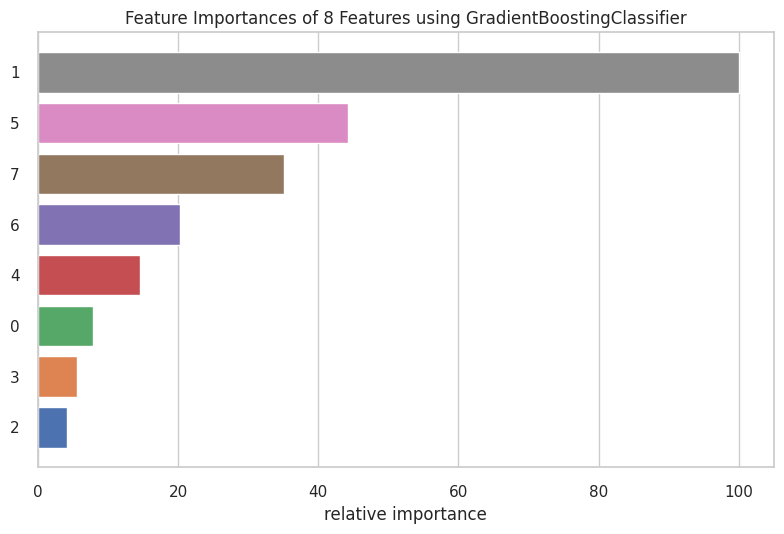

<Axes: title={'center': 'Feature Importances of 8 Features using GradientBoostingClassifier'}, xlabel='relative importance'>

In [39]:
# Definir el algoritmo de ML
model = GradientBoostingClassifier(learning_rate= 0.01, max_depth= 4, n_estimators= 200)
model.fit(X_train, y_train)

# Mostrar la importancia de características
viz = FeatureImportances(model)
viz.fit(X_train, y_train)
plt.savefig('NoPCANOrm.pdf')
viz.show()


#PCA  Normalizada - Standard Scaler + PCA



In [40]:
dfc3 = df_copy3
X_train, X_test, y_train, y_test = train_test_split(features, labels,test_size=0.20, random_state=1, stratify=labels)
y_train= y_train[:].astype(int)
y_test=y_test[:].astype(int)

In [41]:
#Normalizado
scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [42]:
pca = decomposition.PCA(n_components=0.96,svd_solver='full',tol=1e-4)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test=pca.transform(X_test)

In [43]:
model_DTC = DecisionTreeClassifier(random_state=0)
model_MLP = MLPClassifier(random_state=0, max_iter=500)  # Increased max_iter for MLP
model_KNN = KNeighborsClassifier()
model_SGDC = SGDClassifier(random_state=0)
model_ETC = ExtraTreesClassifier(random_state=0)
model_RF = RandomForestClassifier(random_state=0)
model_GB = GradientBoostingClassifier(random_state=0)

In [44]:
model_DTC.fit(X_train, y_train)
model_MLP.fit(X_train, y_train)
model_KNN.fit(X_train, y_train)
model_SGDC.fit(X_train, y_train)
model_ETC.fit(X_train, y_train)
model_RF.fit(X_train, y_train)
model_GB.fit(X_train, y_train)

GradientBoostingClassifier(random_state=0)

In [45]:
print("DTC, Accuracy: ", model_DTC.score(X_test, y_test))
print("MLP, Accuracy: ", model_MLP.score(X_test, y_test))
print("KNN, Accuracy: ", model_KNN.score(X_test, y_test))
print("SGDC, Accuracy: ", model_SGDC.score(X_test, y_test))
print("ETC, Accuracy: ", model_ETC.score(X_test, y_test))
print("RF, Accuracy: ", model_RF.score(X_test, y_test))
print("GB, Accuracy: ", model_GB.score(X_test, y_test))

DTC, Accuracy:  0.7207792207792207
MLP, Accuracy:  0.7597402597402597
KNN, Accuracy:  0.7207792207792207
SGDC, Accuracy:  0.7077922077922078
ETC, Accuracy:  0.7532467532467533
RF, Accuracy:  0.7467532467532467
GB, Accuracy:  0.7337662337662337


In [46]:
models = {
    "DTC": model_DTC,
    "MLP": model_MLP,
    "KNN": model_KNN,
    "SGDC": model_SGDC,
    "ETC": model_ETC,
    "RF": model_RF,
    "GB": model_GB
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred) * 100
    precision = precision_score(y_test, y_pred, average='weighted') * 100
    recall = recall_score(y_test, y_pred, average='weighted') * 100
    f1 = f1_score(y_test, y_pred, average='weighted') * 100

    print(f"{name}, Accuracy: {accuracy:.2f}%, Precision: {precision:.2f}%, Recall: {recall:.2f}%, F1: {f1:.2f}%")

DTC, Accuracy: 72.08%, Precision: 72.20%, Recall: 72.08%, F1: 72.14%
MLP, Accuracy: 75.97%, Precision: 75.39%, Recall: 75.97%, F1: 75.40%
KNN, Accuracy: 72.08%, Precision: 71.56%, Recall: 72.08%, F1: 71.74%
SGDC, Accuracy: 70.78%, Precision: 70.66%, Recall: 70.78%, F1: 70.72%
ETC, Accuracy: 75.32%, Precision: 74.65%, Recall: 75.32%, F1: 74.48%
RF, Accuracy: 74.68%, Precision: 73.97%, Recall: 74.68%, F1: 73.52%
GB, Accuracy: 73.38%, Precision: 72.75%, Recall: 73.38%, F1: 72.90%


In [47]:
model_MLP = MLPClassifier()

param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'learning_rate_init': [0.01, 0.001],
    'max_iter': [200, 500]
}

grid_search = GridSearchCV(model_MLP, param_grid, cv=5, verbose=0)

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

print("Mejores hiperparámetros:", best_params)

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

Mejores hiperparámetros: {'activation': 'tanh', 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001, 'max_iter': 200}


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
<ipython-input-48-a5e6ae6830cf>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


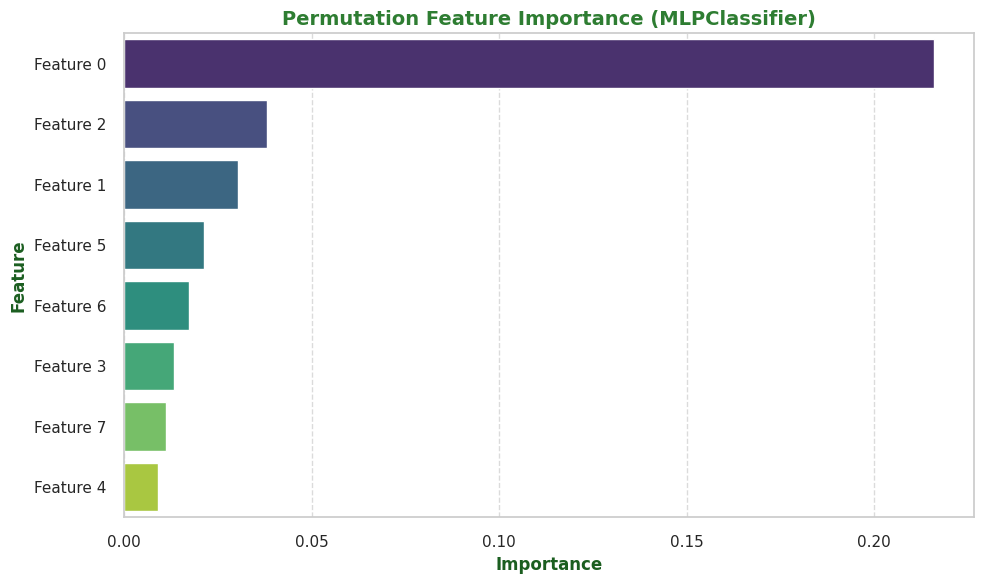

In [48]:
# Entrenar el modelo
model = MLPClassifier(hidden_layer_sizes=(50,), learning_rate_init=0.001, max_iter=200)
model.fit(X_train, y_train)

# Calcular la importancia de las características
result = permutation_importance(model, X_train, y_train, n_repeats=10, random_state=42)
importances = result.importances_mean

# Crear DataFrame para visualizar
feature_names = [f"Feature {i}" for i in range(X_train.shape[1])]  # Reemplazar con nombres reales si están disponibles
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})

# Ordenar por importancia
importance_df = importance_df.sort_values("Importance", ascending=False)

# Crear gráfico de barras con colores distintos para cada barra
plt.figure(figsize=(10, 6))
sns.barplot(
    x="Importance",
    y="Feature",
    data=importance_df,
    palette=sns.color_palette("viridis", len(importance_df))  # Cambia "viridis" por otra paleta si quieres
)

# Personalizar el gráfico
plt.title("Permutation Feature Importance (MLPClassifier)", fontsize=14, fontweight="bold", color="#2E7D32")
plt.xlabel("Importance", fontsize=12, fontweight="bold", color="#1B5E20")
plt.ylabel("Feature", fontsize=12, fontweight="bold", color="#1B5E20")
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Guardar y mostrar
plt.tight_layout()
plt.savefig("PCANorm.pdf")
plt.show()

#Evaluación con greedsearch

In [49]:
#SinPCA Sin Normalizar
df2 = pd.read_csv('/content/diabetes.csv')
X_train, X_test, y_train, y_test = train_test_split(features, labels,test_size=0.20, random_state=1, stratify=labels)
y_train= y_train[:].astype(int)
y_test=y_test[:].astype(int)
model_GB  = GradientBoostingClassifier(learning_rate= 0.01, max_depth= 4, n_estimators= 200)
model_GB.fit(X_train, y_train)
print("GB, Accuracy: ", model_GB.score(X_test, y_test))

y_pred=model_GB.predict(X_test)
print(classification_report(y_test,y_pred))

GB, Accuracy:  0.7467532467532467
              precision    recall  f1-score   support

           0       0.77      0.87      0.82       100
           1       0.68      0.52      0.59        54

    accuracy                           0.75       154
   macro avg       0.73      0.69      0.70       154
weighted avg       0.74      0.75      0.74       154



In [50]:
#PCA Sin normalizar
dfc4 = df_copy4
X_train, X_test, y_train, y_test = train_test_split(features, labels,test_size=0.20, random_state=1, stratify=labels)
y_train= y_train[:].astype(int)
y_test=y_test[:].astype(int)


pca = decomposition.PCA(n_components=0.96,svd_solver='full',tol=1e-4)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test=pca.transform(X_test)

model_RF  = RandomForestClassifier(max_depth= 10, min_samples_leaf= 4, min_samples_split= 10, n_estimators= 50)
model_RF.fit(X_train, y_train)
print("RF, Accuracy: ", model_RF.score(X_test, y_test))

y_pred=model_RF.predict(X_test)
print(classification_report(y_test,y_pred))


RF, Accuracy:  0.7597402597402597
              precision    recall  f1-score   support

           0       0.78      0.87      0.82       100
           1       0.70      0.56      0.62        54

    accuracy                           0.76       154
   macro avg       0.74      0.71      0.72       154
weighted avg       0.75      0.76      0.75       154



In [51]:
#sinPCA Normalizada
dfc5 = df_copy5
X_train, X_test, y_train, y_test = train_test_split(features, labels,test_size=0.20, random_state=1, stratify=labels)
y_train= y_train[:].astype(int)
y_test=y_test[:].astype(int)
scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

model_GB  = GradientBoostingClassifier(learning_rate= 0.01, max_depth= 4, n_estimators= 200)
model_GB.fit(X_train, y_train)
print("GB, Accuracy: ", model_GB.score(X_test, y_test))

y_pred=model_GB.predict(X_test)
print(classification_report(y_test,y_pred))



GB, Accuracy:  0.7467532467532467
              precision    recall  f1-score   support

           0       0.77      0.87      0.82       100
           1       0.68      0.52      0.59        54

    accuracy                           0.75       154
   macro avg       0.73      0.69      0.70       154
weighted avg       0.74      0.75      0.74       154



In [52]:
#PCA normalizar
dfc6 = df_copy6
X_train, X_test, y_train, y_test = train_test_split(features, labels,test_size=0.20, random_state=1, stratify=labels)
y_train= y_train[:].astype(int)
y_test=y_test[:].astype(int)

scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


pca = decomposition.PCA(n_components=0.96,svd_solver='full',tol=1e-4)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test=pca.transform(X_test)

model_MLP  = MLPClassifier(hidden_layer_sizes= (50,), learning_rate_init= 0.001, max_iter= 200)  # You might need to adjust max_iter
model_MLP.fit(X_train, y_train)
print("MLP, Accuracy: ", model_MLP.score(X_test, y_test))
print(classification_report(y_test,y_pred))

MLP, Accuracy:  0.7467532467532467
              precision    recall  f1-score   support

           0       0.77      0.87      0.82       100
           1       0.68      0.52      0.59        54

    accuracy                           0.75       154
   macro avg       0.73      0.69      0.70       154
weighted avg       0.74      0.75      0.74       154



/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [53]:
model_ET  = ExtraTreesClassifier(random_state=0)
model_ET.fit(X_train, y_train)
y_pred=model_ET.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.78      0.87      0.82       100
           1       0.69      0.54      0.60        54

    accuracy                           0.75       154
   macro avg       0.73      0.70      0.71       154
weighted avg       0.75      0.75      0.74       154

